In [27]:
from osgeo import gdal,osr
import fiona
import rasterio.mask
import glob, os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
shfile_path='../shapefiles/'
output_path='../countries/'
input_path='../data2/'

In [16]:
for root,sub,shfiles in os.walk(shfile_path):
    for shfile in shfiles:
        if(shfile.endswith('0.shp')):
            print('Processing ',shfile[:3])
            with fiona.open(root+'/'+shfile, 'r') as shapefile:
                features = [feature['geometry'] for feature in shapefile]
            dirname=shfile[:3]
            if not os.path.exists(output_path+'/'+dirname):
                os.makedirs(output_path+'/'+dirname)
            for wfile in os.listdir(input_path):
                if(wfile.endswith('.tif')):
                    with rasterio.open(input_path+"/"+wfile) as src:
                        out_image, out_transform = rasterio.mask.mask(src, features, crop=True)
                        out_meta = src.meta.copy()

                    out_meta.update({"driver": "GTiff",
                                "height": out_image.shape[1],
                                "width": out_image.shape[2],
                                "transform": out_transform})

                    with rasterio.open(output_path+'/'+dirname+'/'+wfile, "w", **out_meta) as dest:
                        dest.write(out_image)
        

Processing  SYC
Processing  PNG
Processing  BFA
Processing  MOZ
Processing  MLI
Processing  ZMB
Processing  BWA
Processing  GMB
Processing  SOM
Processing  DZA
Processing  MRT
Processing  RWA
Processing  ERI
Processing  GIN
Processing  SEN
Processing  GNQ
Processing  MAR
Processing  MDG
Processing  LBY
Processing  COM
Processing  MUS
Processing  MWI
Processing  LSO
Processing  DJI
Processing  TCD
Processing  STP
Processing  LBR
Processing  GHA
Processing  TGO
Processing  ZAF
Processing  AGO
Processing  NER
Processing  BDI
Processing  EGY
Processing  NGA
Processing  TZA
Processing  GAB
Processing  ETH
Processing  SLE
Processing  SDN
Processing  UGA
Processing  CMR
Processing  SWZ
Processing  TUN
Processing  KEN
Processing  NAM
Processing  ZWE
Processing  BEN
Processing  GNB


In [77]:
load_text_file = 'input_for_calibration'
cof_data = np.loadtxt(load_text_file)
country_path=output_path
raster1band_path='../output/raster1/'
plt_path='../output/plots/'
if not os.path.exists(plt_path):
    os.makedirs(plt_path)

In [75]:
cofficient_from_data={}
for i in cof_data:
    cofficient_from_data[i[0]]=i[:0:-1]
#print(cofficient_from_data.get(1989.0) is not None)
#cofficient_from_data

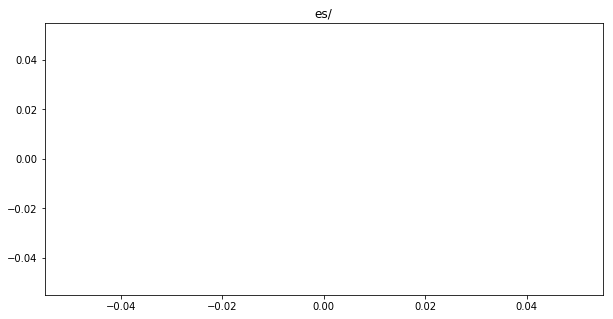

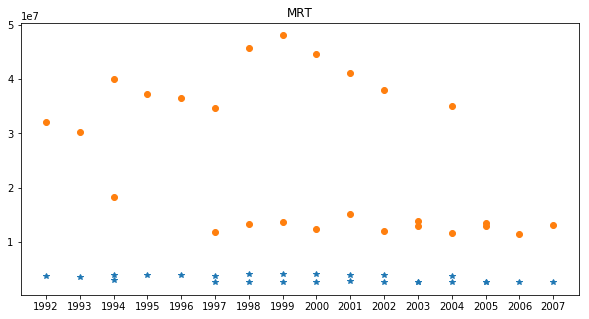

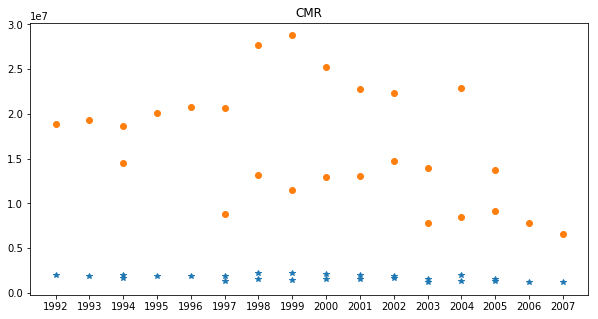

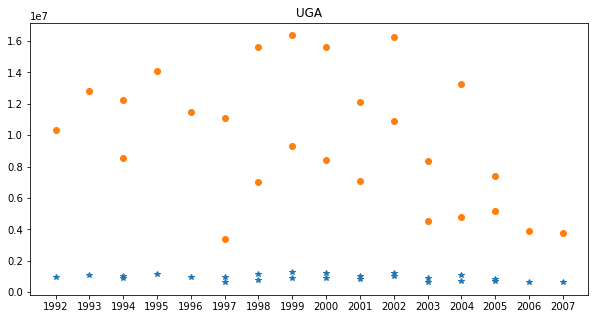

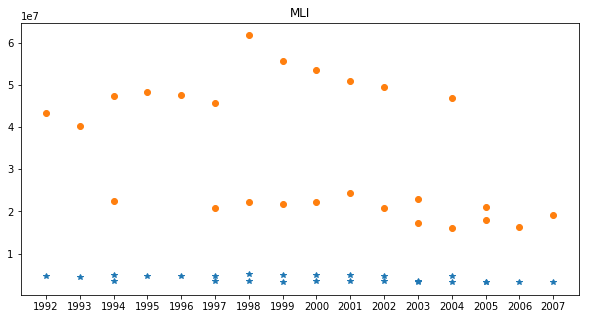

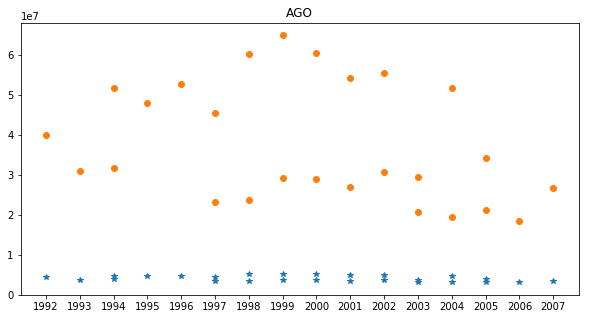

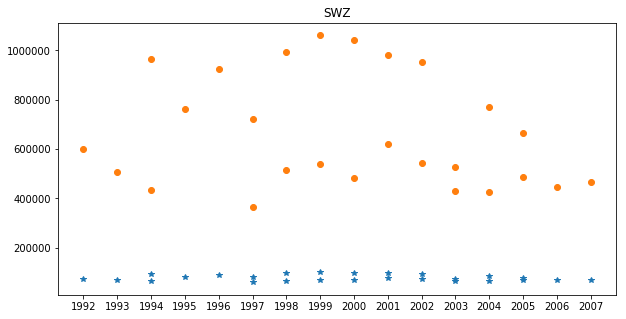

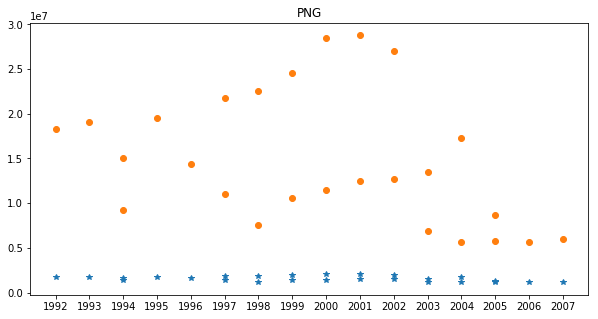

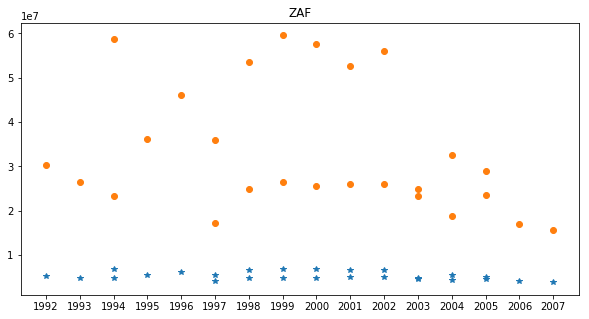

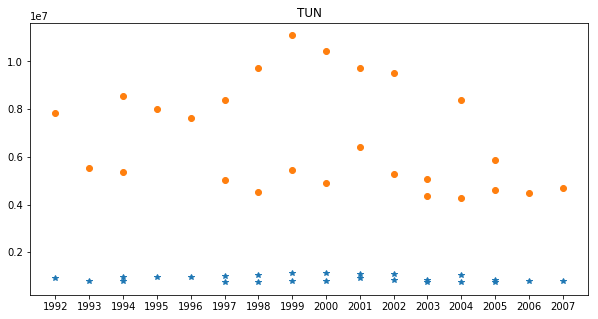

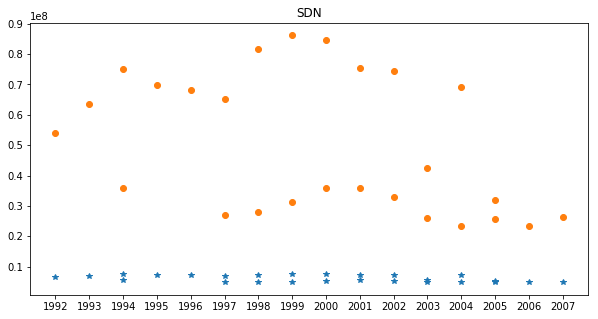

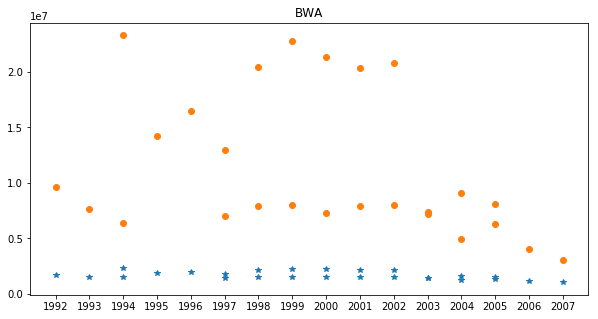

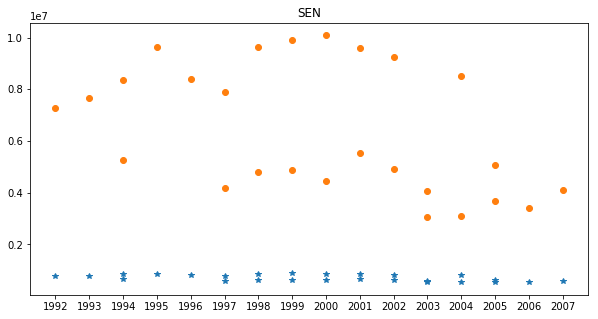

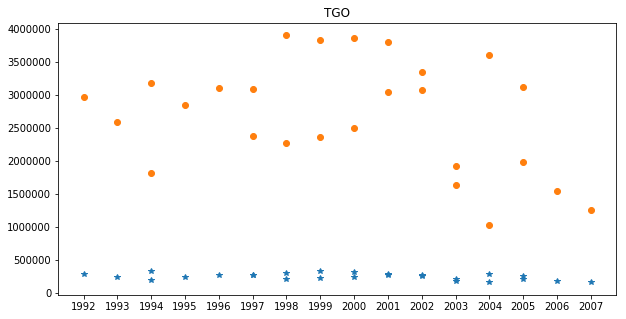

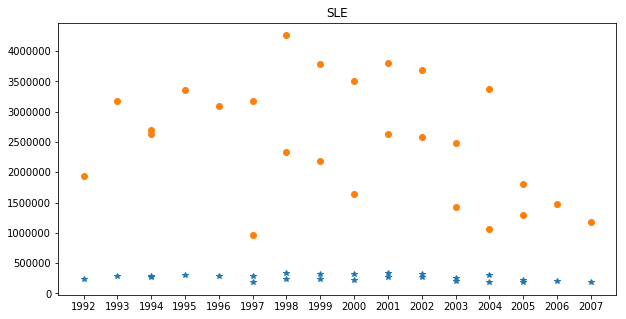

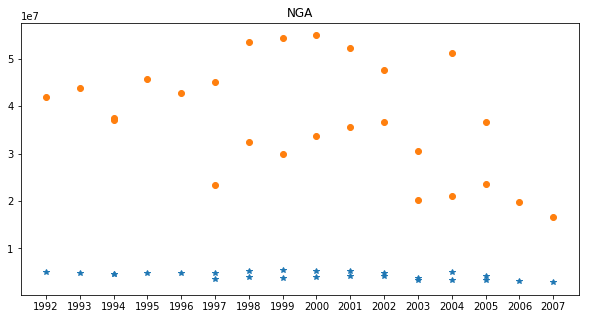

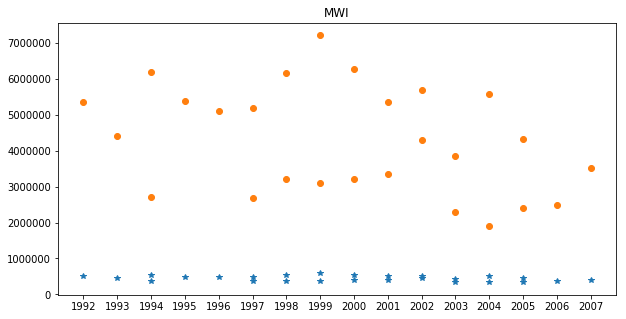

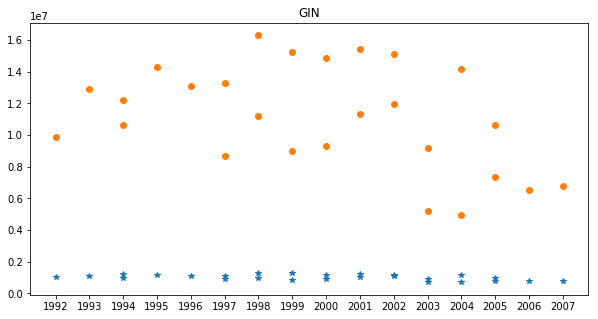

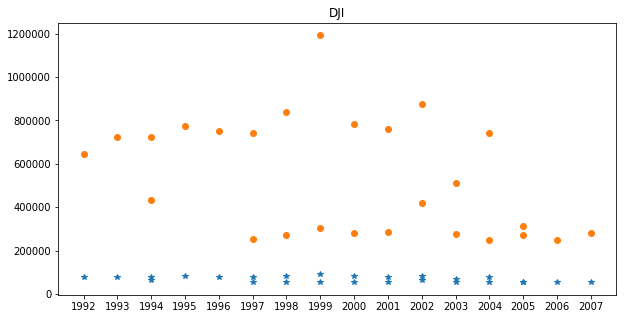

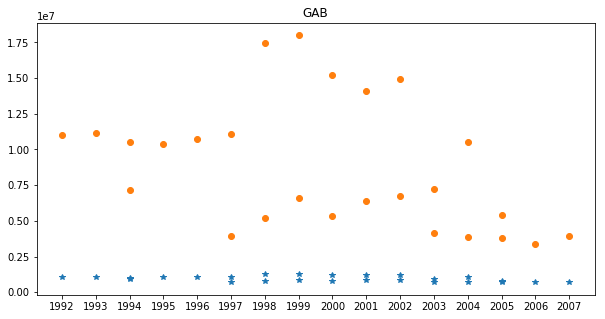

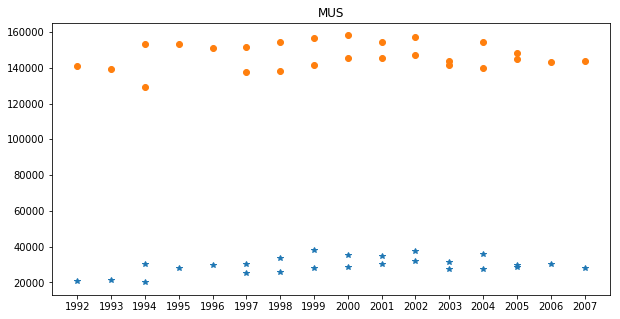

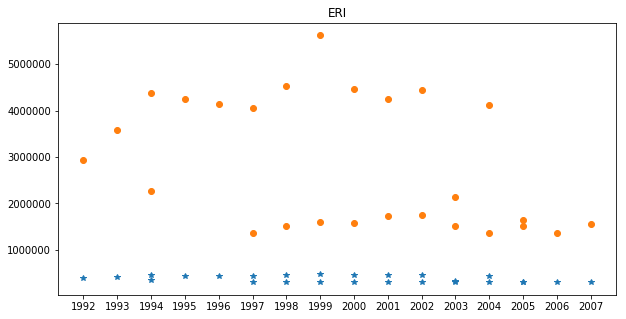

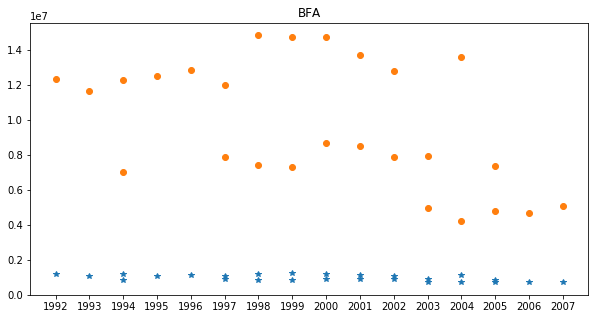

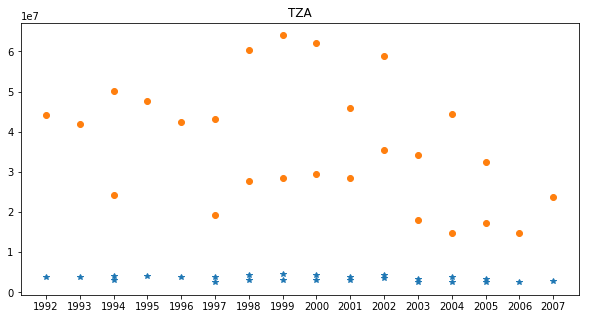

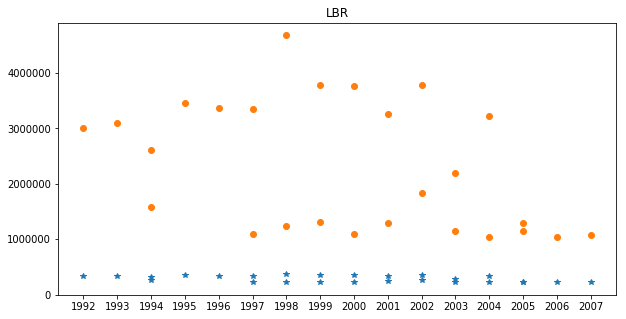

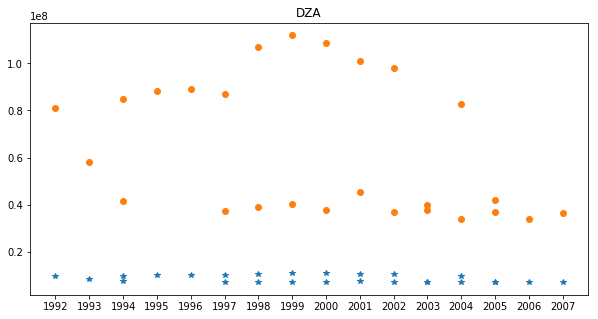

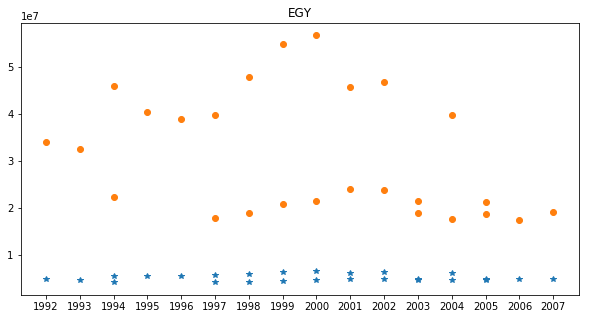

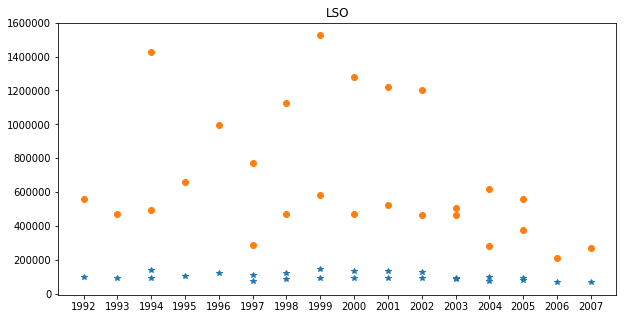

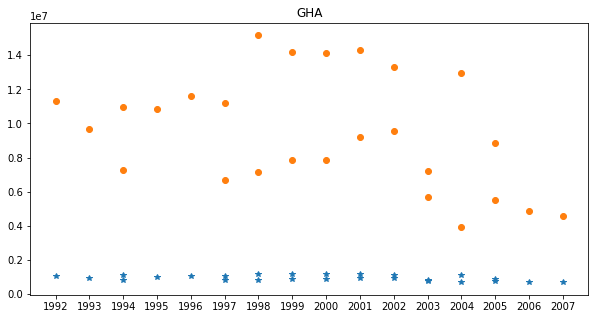

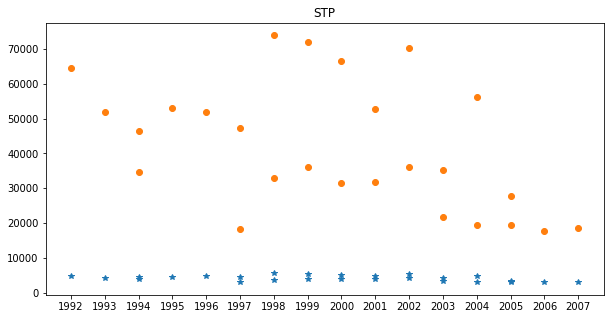

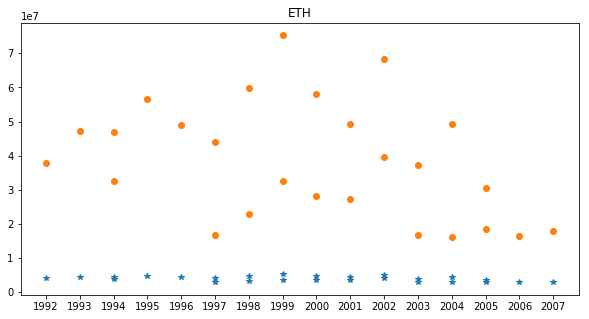

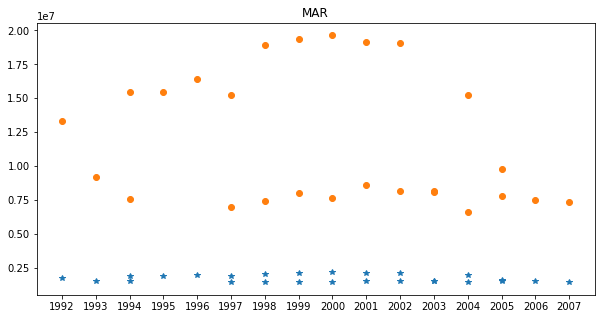

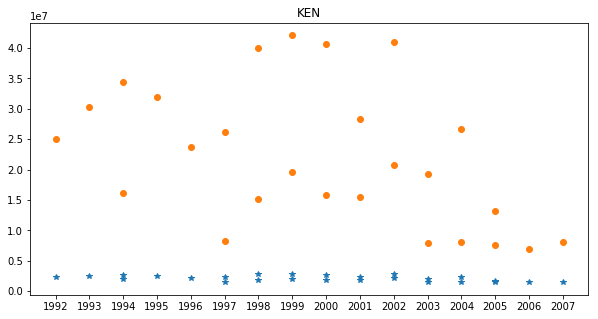

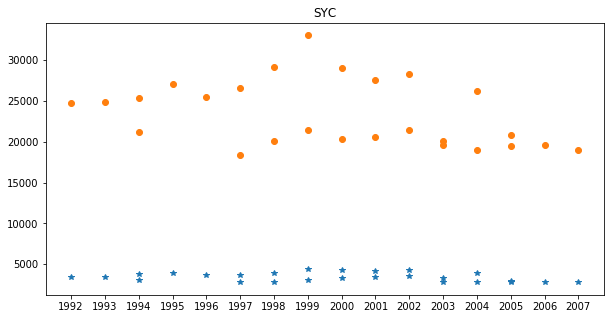

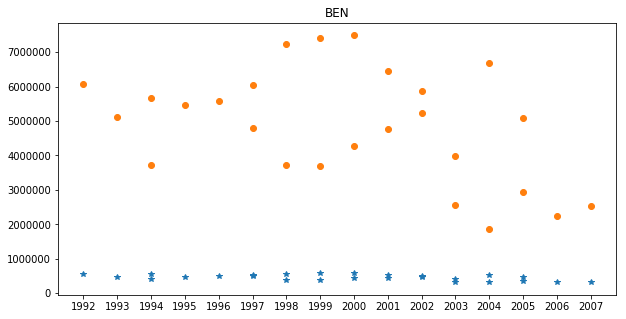

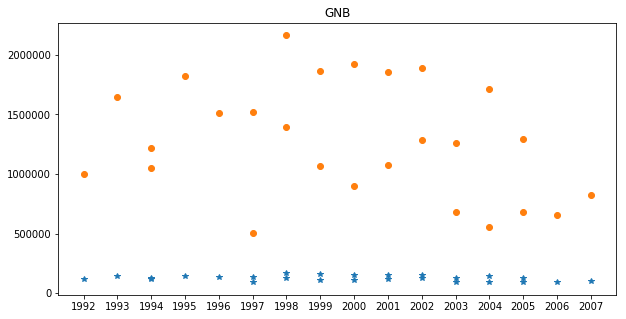

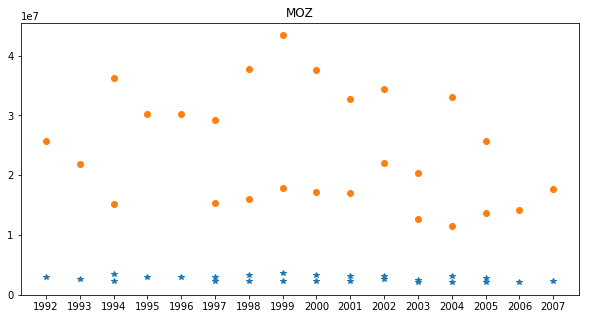

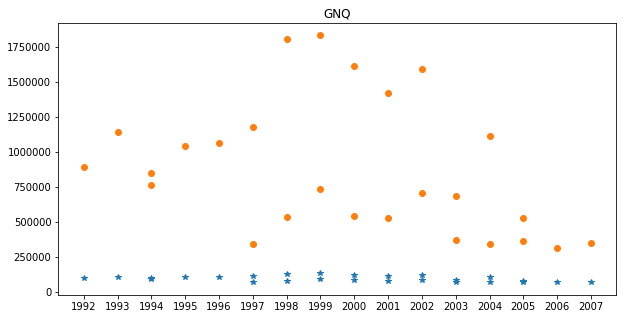

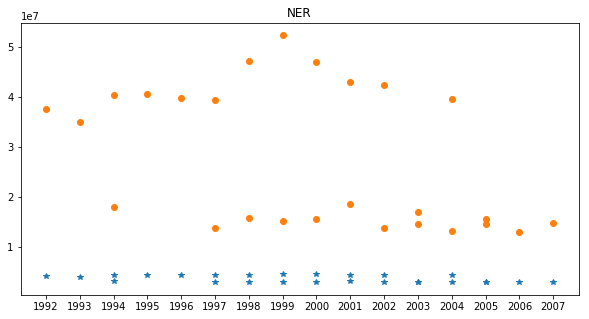

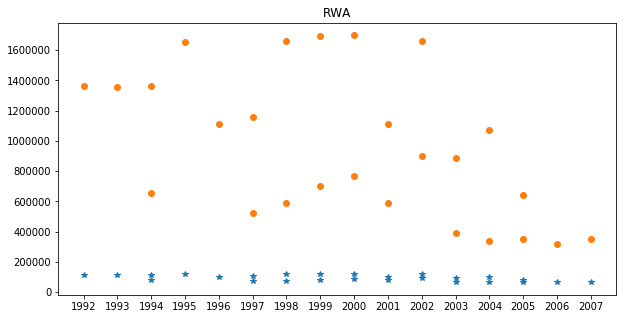

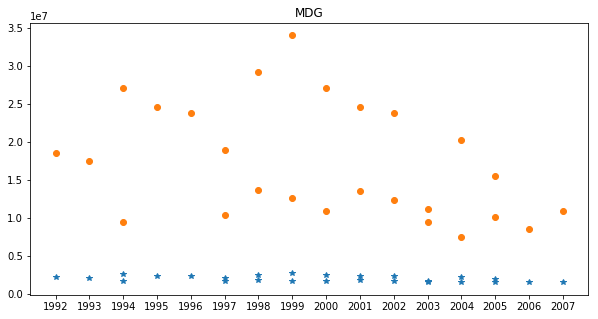

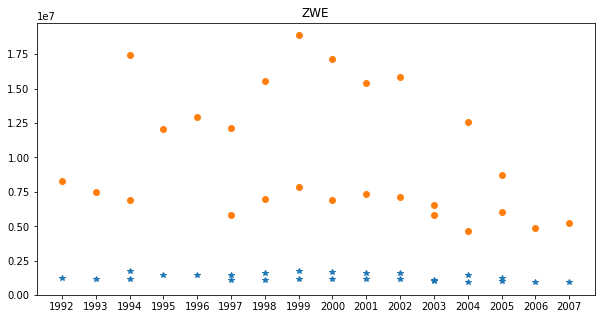

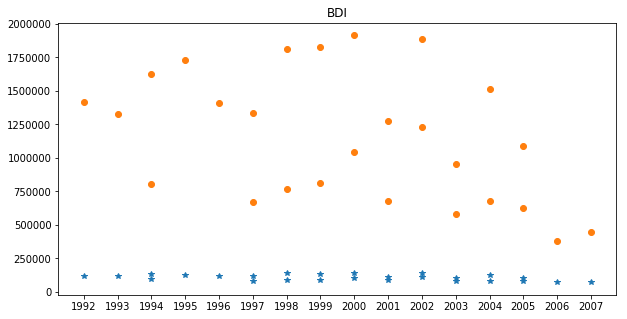

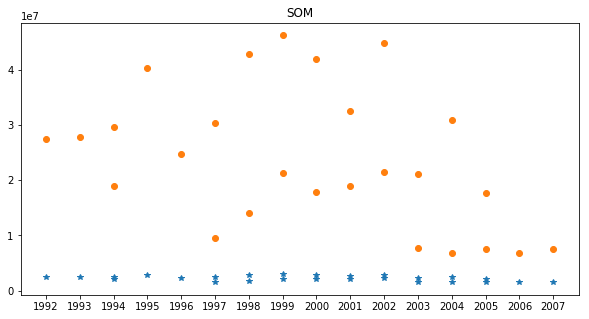

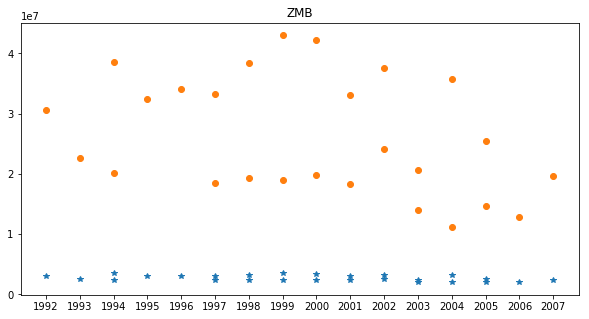

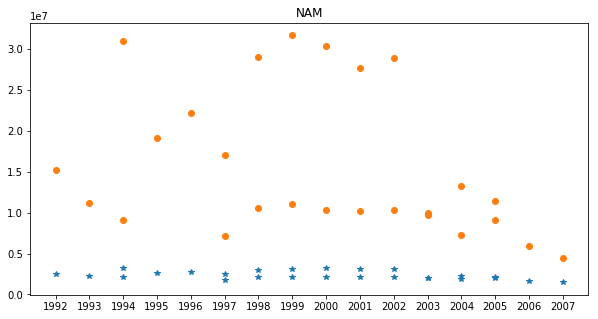

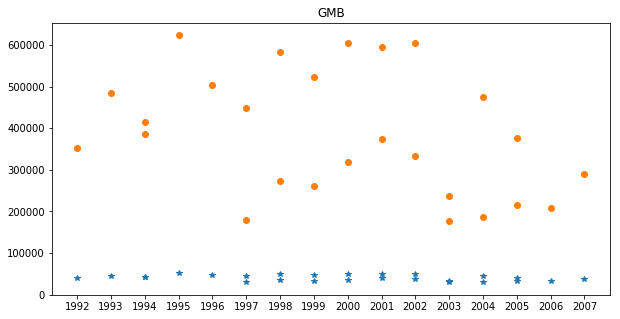

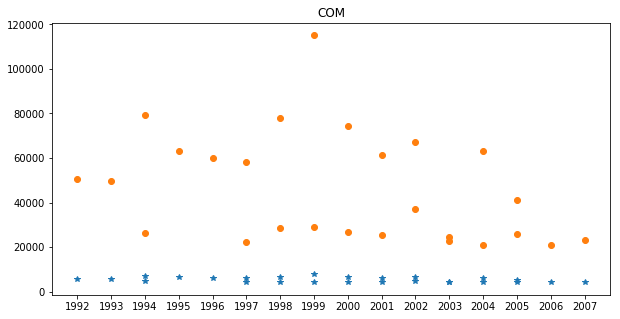

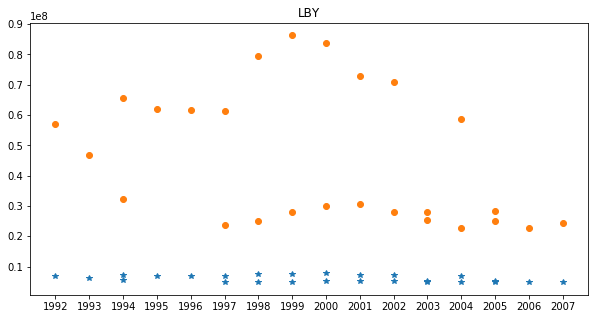

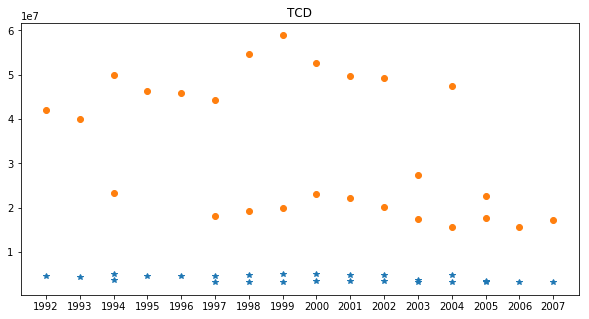

In [78]:
count=0
for root,sub,files in os.walk(country_path):
    y_axis=[]       
    dn_before_correlation = []
    dn_after_data = []
    #a=set()
    if(len(sub)>0):
        for s in sub:
            if not os.path.exists(raster1band_path+'/'+s):
                os.makedirs(raster1band_path+'/'+s)
    for file in files:
        if file.endswith('.tif'): 
            
            gtif_candidate = gdal.Open(root+"/"+file, gdal.GA_ReadOnly )
            
            # Read initial tif info
            rb_candidate = gtif_candidate.GetRasterBand(1)
            img_array_candidate = rb_candidate.ReadAsArray()
            h, w = img_array_candidate.shape

            # Flatten data for regression
            x_before_correlation = img_array_candidate.flatten()

            # Load regression cofficient from the text file, polyfit() works as Ax^2+ Bx + C, but
            # cofficient are given as A + Bx + Cx^2, so we do a flip()
            #y_axis.append(cofficient_from_data[count, 0])
            if cofficient_from_data[float(file[3:7])] is not None:
                y_axis.append(file[3:7])
                regression_cofficient = cofficient_from_data[float(file[3:7])]
                #regression_cofficient = np.flip(regression_cofficient, axis=0)

                # Use polyfit() model for calibration with regression coefficient
                poly_fit_again = np.poly1d(regression_cofficient)
                x_after_data = poly_fit_again(x_before_correlation)

                # MOre calibration based on paper
                x_after_data[x_after_data < 3] = 0
                x_after_data[x_after_data > 63] = 63

                # For plotting the graph, save total DN values sum
                dn_before_correlation.append(np.sum(x_before_correlation,dtype=np.int64))
                dn_after_data.append(np.sum(x_after_data,dtype=np.int64))


                #count += 1

                # For savin gnew calibrated file get initial info
                raster_updated = x_after_data.reshape(h, w)
                image_size = raster_updated.shape

                # set geotransform
                nx = image_size[0]
                ny = image_size[1]
                geotransform = gtif_candidate.GetGeoTransform()

                # create the 1-band raster file
                dst_ds = gdal.GetDriverByName('GTiff').Create(raster1band_path+root[root.rfind('/'):]+'/'+file, ny, nx, 1, gdal.GDT_Byte)

                dst_ds.SetGeoTransform(geotransform)  # specify coords
                srs = osr.SpatialReference()  # establish encoding
                srs.ImportFromEPSG(3857)  # WGS84 lat/long
                dst_ds.SetProjection(srs.ExportToWkt())  # export coords to file
                dst_ds.GetRasterBand(1).WriteArray(raster_updated)  # write r-band to the raster

                dst_ds.FlushCache()  # write to disk
                dst_ds = None

                #fig1 = plt.figure()
                #plt.scatter(x_before_correlation, x_after_correlation, alpha=0.5)
                #plt.show()
                #fig1.savefig(file_path_output+file+".png")
    fig=plt.figure(figsize=(10,5))
    plt.title(root[-3:])
    plt.plot(y_axis,dn_before_correlation,'*', y_axis,dn_after_data, 'o')
    plt.show()
    fig.savefig(plt_path+'/'+root[root.rfind('/'):].strip('/'))